In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import skew, kurtosis

import re

#for text feature extraction
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from bs4 import BeautifulSoup

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# Set a font that supports a wide range of characters
plt.rcParams['font.family'] = 'Arial'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load all clean data
df_customers = pd.read_csv('data/cleaned_data/customers.csv')
df_products = pd.read_csv('data/cleaned_data/products.csv')
df_orders = pd.read_csv('data/cleaned_data/orders.csv', low_memory=False)

In [3]:
pd.set_option('display.max_columns', None) 
df_customers.describe(include='all')

,customer_id,accepts_email_marketing,default_address_city,default_address_country_code,default_address_zip,accepts_sms_marketing,total_spent,total_orders,default_address_company_status,avg_spent_per_order
count,78902,78902,71720,72772,71707,78902,78902.000000,78902.000000,4178,78902.000000
unique,78902,2,24363,31,9496,2,NaN,NaN,1,NaN
top,'3220287651979,no,PARIS,FR,75015,no,NaN,NaN,not null,NaN
freq,1,55268,2301,62624,260,76292,NaN,NaN,4178,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,60.160114,1.143368,NaN,40.467935
std,NaN,NaN,NaN,NaN,NaN,NaN,226.607335,3.581468,NaN,39.785659
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,22.940000,1.000000,NaN,22.790000
50%,NaN,NaN,NaN,NaN,NaN,NaN,38.430000,1.000000,NaN,35.940000
75%,NaN,NaN,NaN,NaN,NaN,NaN,63.357500,1.000000,NaN,53.880000


In [4]:
# Convert 'accepts_email_marketing' to binary
df_customers['accepts_email_marketing'] = df_customers['accepts_email_marketing'].map({'yes': 1, 'no': 0})

In [5]:
# Handle 'default_address_city': Encode top N cities, group others as 'other'
top_cities = df_customers['default_address_city'].value_counts().index[:50]
df_customers['default_address_city'] = df_customers['default_address_city'].apply(lambda x: x if x in top_cities else 'other')

# One-hot encode 'default_address_city'
df_customers = pd.get_dummies(df_customers, columns=['default_address_city'], prefix='city')

In [6]:
df_customers.shape

(78902, 60)

In [7]:
# One-hot encode 'default_address_country_code'
df_customers = pd.get_dummies(df_customers, columns=['default_address_country_code'], prefix='country')

In [8]:
df_customers.shape

(78902, 90)

In [9]:
# Handle 'default_address_zip': Group by the first digit
df_customers['zip_region'] = df_customers['default_address_zip'].apply(lambda x: str(x)[0] if pd.notna(x) else x)

# One-hot encode 'zip_region'
df_customers = pd.get_dummies(df_customers, columns=['zip_region'], prefix='zip')

# Drop the original 'default_address_zip' column as it's now represented by 'zip_region'
df_customers.drop(columns=['default_address_zip'], inplace=True)

In [10]:
df_customers.shape

(78902, 123)

In [11]:
# Convert 'accepts_sms_marketing' to binary
df_customers['accepts_sms_marketing'] = df_customers['accepts_sms_marketing'].map({'yes': 1, 'no': 0})

In [12]:
# Convert 'default_address_company_status' to binary
df_customers['default_address_company_status'] = np.where(df_customers['default_address_company_status'].notnull(), 1, 0)


In [13]:
df_customers.describe(include='all')

,customer_id,accepts_email_marketing,accepts_sms_marketing,total_spent,total_orders,default_address_company_status,avg_spent_per_order,city_AIX EN PROVENCE,city_AJACCIO,city_AMIENS,city_ANGERS,city_ANNECY,city_ANTIBES,city_ARGENTEUIL,city_BORDEAUX,city_BOULOGNE-BILLANCOURT,city_BREST,city_BRUXELLES,city_CAEN,city_CANNES,city_COLOMBES,city_COURBEVOIE,city_DIJON,city_FONDETTES,city_GRENOBLE,city_LA ROCHELLE,city_LE HAVRE,city_LE MANS,city_LILLE,city_LIMOGES,city_LYON,city_MARSEILLE,city_METZ,city_MILANO,city_MONTPELLIER,city_MONTREUIL,city_NANCY,city_NANTERRE,city_NANTES,city_NAPOLI,city_NICE,city_PARIS,city_PERPIGNAN,city_REIMS,city_RENNES,city_ROMA,city_ROUEN,city_SAINT AVERTIN,city_SAINT-AVERTIN,city_STRASBOURG,city_TORINO,city_TOULON,city_TOULOUSE,city_TOURCOING,city_TOURS,city_VERSAILLES,city_VILLEURBANNE,city_other,country_AF,country_AT,country_BE,country_BL,country_CA,country_CH,country_CZ,country_DE,country_ES,country_FR,country_GB,country_GF,country_GP,country_HU,country_IT,country_LU,country_MC,country_MF,country_MQ,country_MU,country_NC,country_NL,country_PF,country_PL,country_PM,country_PT,country_RE,country_RO,country_SE,country_US,country_YT,zip_',zip_.,zip_0,zip_1,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zip_J,zip_K,zip_L,zip_M,zip_N,zip_O,zip_P,zip_R,zip_S,zip_T,zip_U,zip_W,zip_Y
count,78902,78902.000000,78902.000000,78902.000000,78902.000000,78902.000000,78902.000000,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902
unique,78902,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,'3220287651979,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,78828,78821,78787,78791,78814,78826,78830,78648,78833,78818,78821,78833,78831,78826,78809,78766,78826,78771,78830,78777,78804,78747,78825,78395,78298,78801,78612,78675,78803,78812,78822,78659,78818,78561,76601,78814,78791,78751,78390,78815,78814,78825,78674,78777,78764,78502,78833,78548,78807,78766,68992,78901,78895,77427,78897,78895,78659,78901,78835,78773,62624,78744,78864,78757,78901,71687,78851,78862,78897,78763,78899,78883,78892,78877,78899,78899,78854,78714,78872,78898,78836,78880,74131,78901,78900,72693,72542,68076,73013,72336,70925,68995,73615,71162,78900,78892,78894,78898,78891,78901,78897,78894,78900,78899,78900,78892,78897,78881,78901,78897,78900,78861,78891,78899,78886,78901
mean,NaN,0.299536,0.033079,60.160114,1.143368,0.052952,40.467935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Numerical values in df_customers

In [14]:
print("Skewness of total_spent:", skew(df_customers['total_spent']))
print("Kurtosis of total_spent:", kurtosis(df_customers['total_spent']))

print("Skewness of total_orders:", skew(df_customers['total_orders']))
print("Kurtosis of total_orders:", kurtosis(df_customers['total_orders']))

print("Skewness of average_order_value:", skew(df_customers['avg_spent_per_order']))
print("Kurtosis of average_order_value:", kurtosis(df_customers['avg_spent_per_order']))

Skewness of total_spent: 155.80545712631297
Kurtosis of total_spent: 34376.19567561418
Skewness of total_orders: 204.04940137224594
Kurtosis of total_orders: 50798.22337245496
Skewness of average_order_value: 22.711934127941177
Kurtosis of average_order_value: 2015.52012528353


In [15]:
# Log Transformation
df_customers['log_total_spent'] = np.log1p(df_customers['total_spent'])
df_customers['log_total_orders'] = np.log1p(df_customers['total_orders'])
df_customers['log_avg_spent_per_order'] = np.log1p(df_customers['avg_spent_per_order'])

In [16]:
# Square Root Transformation
df_customers['sqrt_total_spent'] = np.sqrt(df_customers['total_spent'])
df_customers['sqrt_total_orders'] = np.sqrt(df_customers['total_orders'])
df_customers['sqrt_avg_spent_per_order'] = np.sqrt(df_customers['avg_spent_per_order'])

In [17]:
# Box-Cox Transformation (only for strictly positive values)
df_customers['boxcox_total_spent'], _ = stats.boxcox(df_customers['total_spent'] + 1)
df_customers['boxcox_total_orders'], _ = stats.boxcox(df_customers['total_orders'] + 1)
df_customers['boxcox_avg_spent_per_order'], _ = stats.boxcox(df_customers['avg_spent_per_order'] + 1)

# Yeo-Johnson Transformation (can handle zero and negative values)
df_customers['yeojohnson_total_spent'], _ = stats.yeojohnson(df_customers['total_spent'])
df_customers['yeojohnson_total_orders'], _ = stats.yeojohnson(df_customers['total_orders'])
df_customers['yeojohnson_avg_spent_per_order'], _ = stats.yeojohnson(df_customers['avg_spent_per_order'])

In [18]:
# Min-Max Normalization
scaler = MinMaxScaler()
df_customers['minmax_total_spent'] = scaler.fit_transform(df_customers[['total_spent']])
df_customers['minmax_total_orders'] = scaler.fit_transform(df_customers[['total_orders']])
df_customers['minmax_avg_spent_per_order'] = scaler.fit_transform(df_customers[['avg_spent_per_order']])

# Standardization
scaler = StandardScaler()
df_customers['standard_total_spent'] = scaler.fit_transform(df_customers[['total_spent']])
df_customers['standard_total_orders'] = scaler.fit_transform(df_customers[['total_orders']])
df_customers['standard_avg_spent_per_order'] = scaler.fit_transform(df_customers[['avg_spent_per_order']])


c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

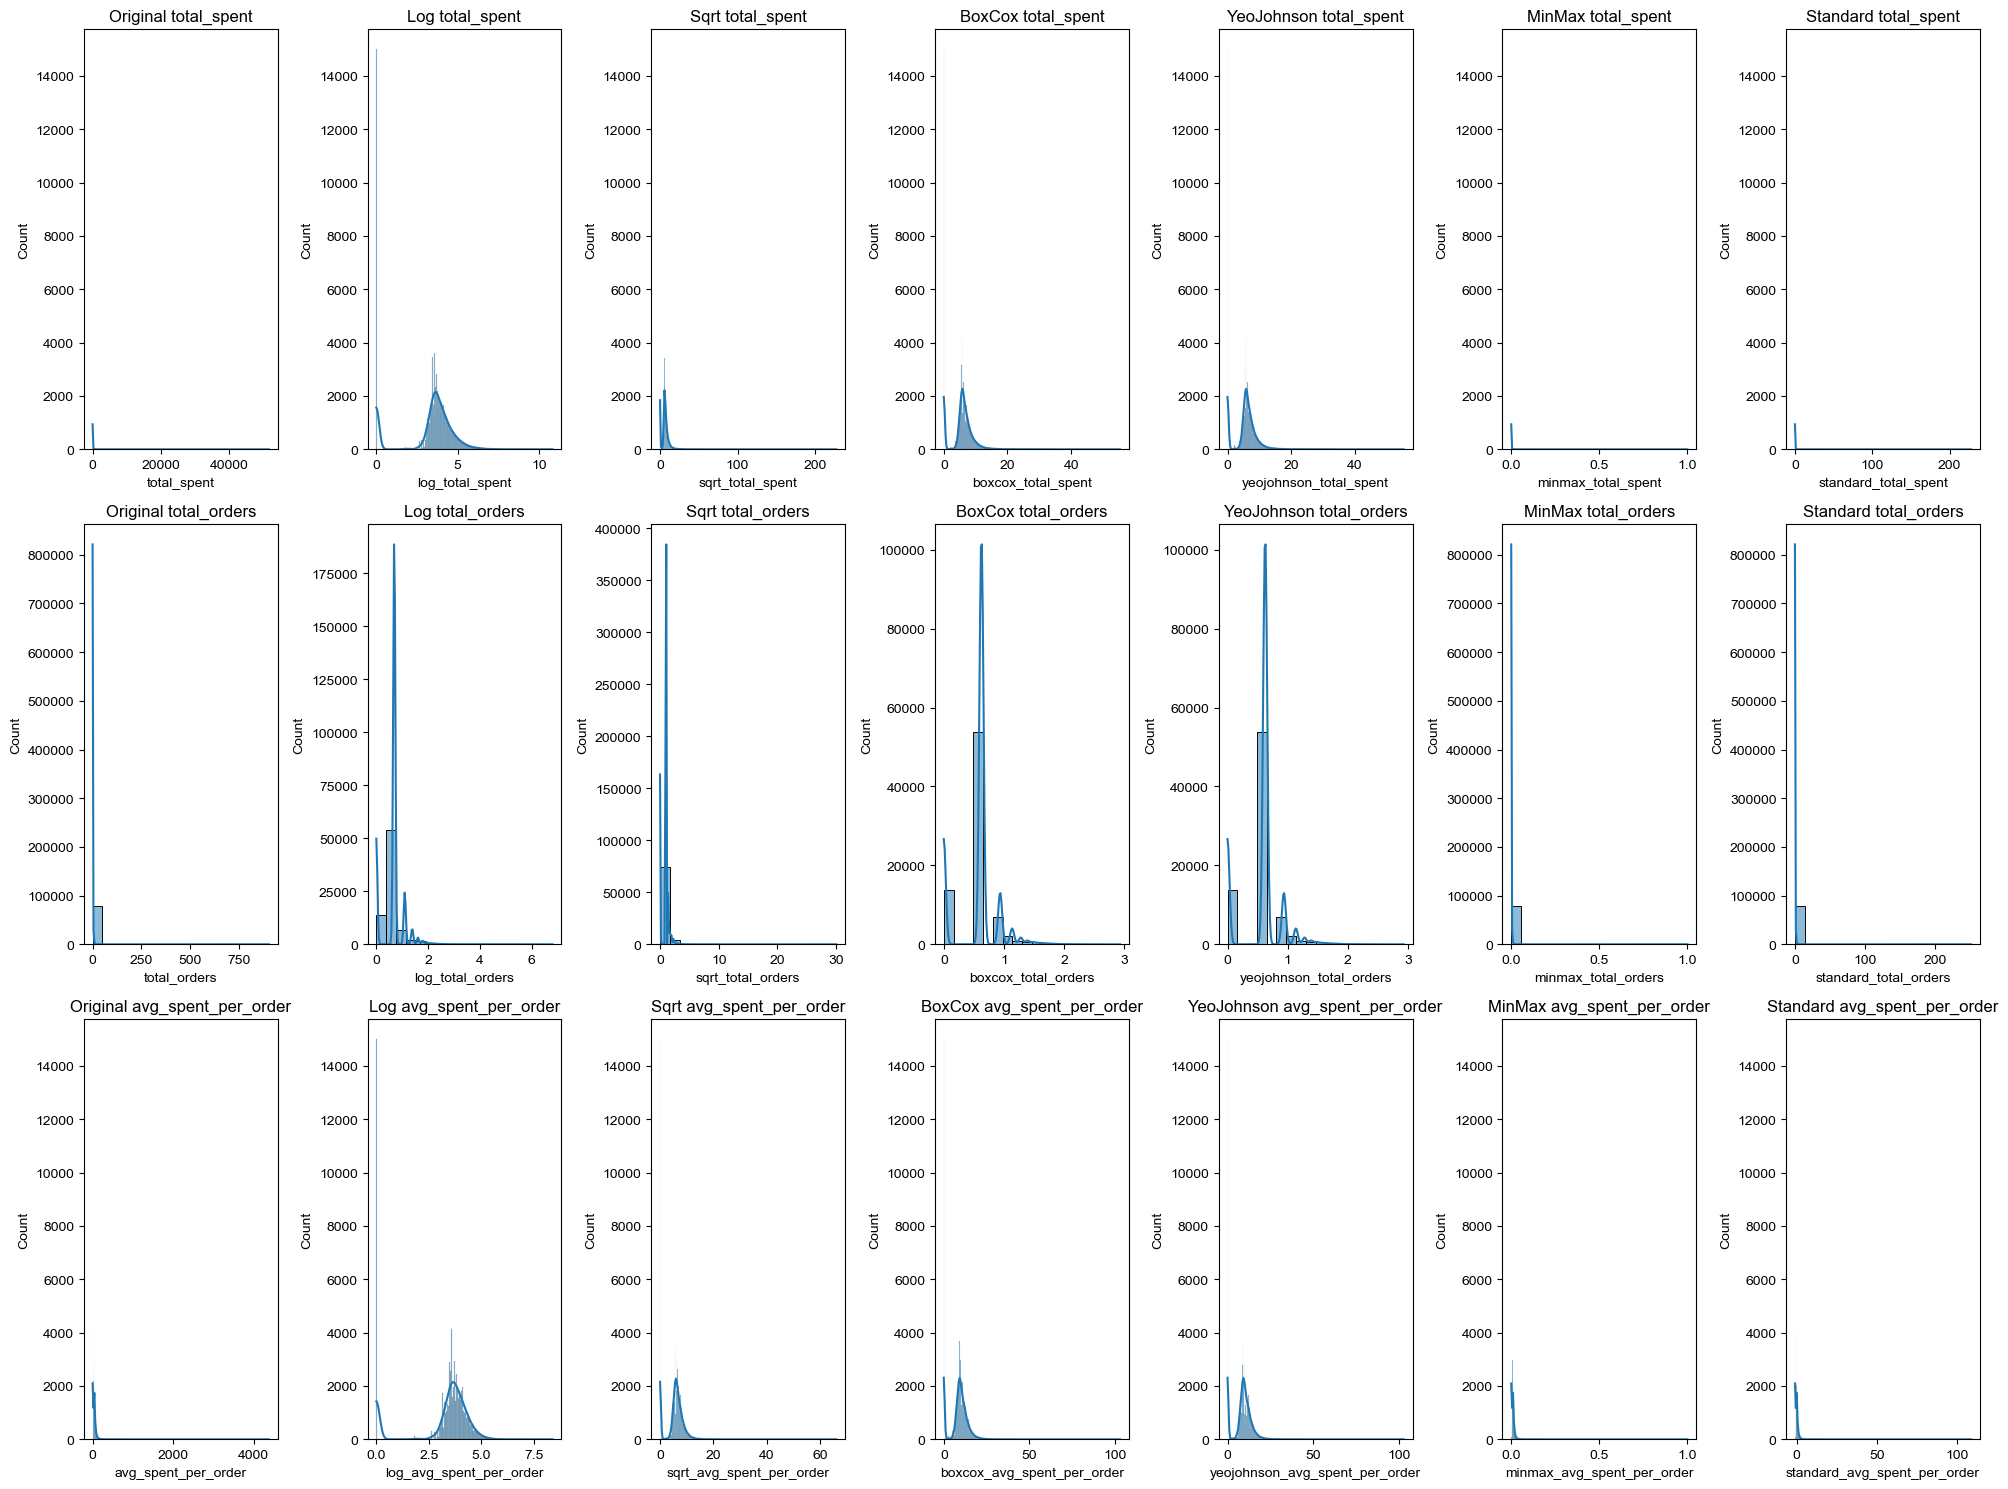

In [19]:
def plot_distributions(df, columns, transformations):
    fig, axes = plt.subplots(len(columns), len(transformations) + 1, figsize=(20, 15))
    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Original {col}')
        for j, (trans_name, trans_col) in enumerate(transformations.items()):
            sns.histplot(df[trans_col[i]], ax=axes[i, j + 1], kde=True)
            axes[i, j + 1].set_title(f'{trans_name} {col}')
    plt.tight_layout()
    plt.show()

# Columns to transform
columns = ['total_spent', 'total_orders', 'avg_spent_per_order']
transformations = {
    'Log': ['log_total_spent', 'log_total_orders', 'log_avg_spent_per_order'],
    'Sqrt': ['sqrt_total_spent', 'sqrt_total_orders', 'sqrt_avg_spent_per_order'],
    'BoxCox': ['boxcox_total_spent', 'boxcox_total_orders', 'boxcox_avg_spent_per_order'],
    'YeoJohnson': ['yeojohnson_total_spent', 'yeojohnson_total_orders', 'yeojohnson_avg_spent_per_order'],
    'MinMax': ['minmax_total_spent', 'minmax_total_orders', 'minmax_avg_spent_per_order'],
    'Standard': ['standard_total_spent', 'standard_total_orders', 'standard_avg_spent_per_order']
}

# Plot the distributions
plot_distributions(df_customers, columns, transformations)

In [21]:
# Calculate skewness and kurtosis for each transformation
results = []

for trans_name, trans_cols in transformations.items():
    for i, col in enumerate(columns):
        skewness = skew(df_customers[trans_cols[i]].dropna())
        kurt = kurtosis(df_customers[trans_cols[i]].dropna(), fisher=False)
        results.append({
            'Column': col,
            'Transformation': trans_name,
            'Skewness': skewness,
            'Kurtosis': kurt
        })

results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Identify the best transformation based on skewness and kurtosis closest to normal (skewness=0, kurtosis=3)
def best_transformation(results_df):
    best_trans = {}
    for col in columns:
        df = results_df[results_df['Column'] == col]
        df['Skewness_Score'] = np.abs(df['Skewness'])
        df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
        df['Total_Score'] = df['Skewness_Score'] + df['Kurtosis_Score']
        best = df.loc[df['Total_Score'].idxmin()]
        best_trans[col] = best['Transformation']
    return best_trans

best_trans = best_transformation(results_df)
print("\nBest transformation for each column:")
print(best_trans)

                 Column Transformation    Skewness      Kurtosis
0           total_spent            Log   -1.006641      3.011320
1          total_orders            Log    0.799109      8.248565
2   avg_spent_per_order            Log   -1.265157      3.104566
3           total_spent           Sqrt    3.486977     91.450992
4          total_orders           Sqrt    2.798394    121.936015
5   avg_spent_per_order           Sqrt   -0.190271      5.926652
6           total_spent         BoxCox    0.052308      5.037222
7          total_orders         BoxCox   -0.075965      4.536767
8   avg_spent_per_order         BoxCox   -0.078634      5.682695
9           total_spent     YeoJohnson    0.052308      5.037222
10         total_orders     YeoJohnson   -0.075965      4.536767
11  avg_spent_per_order     YeoJohnson   -0.078634      5.682695
12          total_spent         MinMax  155.805457  34379.195676
13         total_orders         MinMax  204.049401  50801.223372
14  avg_spent_per_order  

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\1254724235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skewness_Score'] = np.abs(df['Skewness'])
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\1254724235.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\1254724235.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [22]:
# Drop multiple columns
df_customers.drop(['total_spent','total_orders', 'avg_spent_per_order', 'log_total_orders', 'sqrt_total_spent', 'sqrt_total_orders', 'sqrt_avg_spent_per_order', 'boxcox_total_spent', 'boxcox_total_orders', 'boxcox_avg_spent_per_order', 'yeojohnson_total_spent', 'yeojohnson_avg_spent_per_order', 'minmax_total_spent', 'minmax_total_orders', 'minmax_avg_spent_per_order', 'standard_total_spent', 'standard_total_orders', 'standard_avg_spent_per_order'], axis=1, inplace=True)

In [23]:
df_customers.describe(include='all')

,customer_id,accepts_email_marketing,accepts_sms_marketing,default_address_company_status,city_AIX EN PROVENCE,city_AJACCIO,city_AMIENS,city_ANGERS,city_ANNECY,city_ANTIBES,city_ARGENTEUIL,city_BORDEAUX,city_BOULOGNE-BILLANCOURT,city_BREST,city_BRUXELLES,city_CAEN,city_CANNES,city_COLOMBES,city_COURBEVOIE,city_DIJON,city_FONDETTES,city_GRENOBLE,city_LA ROCHELLE,city_LE HAVRE,city_LE MANS,city_LILLE,city_LIMOGES,city_LYON,city_MARSEILLE,city_METZ,city_MILANO,city_MONTPELLIER,city_MONTREUIL,city_NANCY,city_NANTERRE,city_NANTES,city_NAPOLI,city_NICE,city_PARIS,city_PERPIGNAN,city_REIMS,city_RENNES,city_ROMA,city_ROUEN,city_SAINT AVERTIN,city_SAINT-AVERTIN,city_STRASBOURG,city_TORINO,city_TOULON,city_TOULOUSE,city_TOURCOING,city_TOURS,city_VERSAILLES,city_VILLEURBANNE,city_other,country_AF,country_AT,country_BE,country_BL,country_CA,country_CH,country_CZ,country_DE,country_ES,country_FR,country_GB,country_GF,country_GP,country_HU,country_IT,country_LU,country_MC,country_MF,country_MQ,country_MU,country_NC,country_NL,country_PF,country_PL,country_PM,country_PT,country_RE,country_RO,country_SE,country_US,country_YT,zip_',zip_.,zip_0,zip_1,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zip_J,zip_K,zip_L,zip_M,zip_N,zip_O,zip_P,zip_R,zip_S,zip_T,zip_U,zip_W,zip_Y,log_total_spent,log_avg_spent_per_order,yeojohnson_total_orders
count,78902,78902.000000,78902.000000,78902.000000,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902,78902.000000,78902.000000,78902.000000
unique,78902,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN
top,'3220287651979,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,78828,78821,78787,78791,78814,78826,78830,78648,78833,78818,78821,78833,78831,78826,78809,78766,78826,78771,78830,78777,78804,78747,78825,78395,78298,78801,78612,78675,78803,78812,78822,78659,78818,78561,76601,78814,78791,78751,78390,78815,78814,78825,78674,78777,78764,78502,78833,78548,78807,78766,68992,78901,78895,77427,78897,78895,78659,78901,78835,78773,62624,78744,78864,78757,78901,71687,78851,78862,78897,78763,78899,78883,78892,78877,78899,78899,78854,78714,78872,78898,78836,78880,74131,78901,78900,72693,72542,68076,73013,72336,70925,68995,73615,71162,78900,78892,78894,78898,78891,78901,78897,78894,78900,78899,78900,78892,78897,78881,78901,78897,78900,78861,78891,78899,78886,78901,NaN,NaN,NaN
mean,NaN,0.299536,0.033079,0.052952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [24]:
df_customers.to_csv('data/prepared_data/customers.csv', index=False)

## df_products Preparation

In [25]:
df_products = pd.read_csv('data/cleaned_data/products.csv')

In [26]:
df_products.describe(include='all')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,variant_grams,variant_inventory_qty,variant_price,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0
count,402,134,133,86,133,133,134,402,398,402,402.000000,402.000000,402.000000,116,130,33,119,119,102
unique,134,134,133,14,23,118,2,15,15,402,NaN,NaN,NaN,113,120,10,3,3,19
top,culotte-amincissante-ventre-plat,Baume réparateur mains et pieds,"<h5><span style=""color: #000000;"" data-mce-sty...",Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,NaN,NaN,NaN,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging
freq,15,1,1,30,18,5,125,266,118,1,NaN,NaN,NaN,2,4,11,90,62,16
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.940299,36.681592,32.039080,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.704060,43.442548,10.213784,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.830000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,16.000000,27.930000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.000000,25.000000,31.430000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.750000,42.000000,38.430000,NaN,NaN,NaN,NaN,NaN,NaN


## df_products Numerical Features

In [27]:
df_products.describe(include='number')

,variant_grams,variant_inventory_qty,variant_price
count,402.000000,402.000000,402.000000
mean,114.940299,36.681592,32.039080
std,53.704060,43.442548,10.213784
min,0.000000,0.000000,0.830000
25%,85.000000,16.000000,27.930000
50%,108.000000,25.000000,31.430000
75%,137.750000,42.000000,38.430000
max,350.000000,377.000000,59.900000


In [28]:
print("Skewness of variant_price:", skew(df_products['variant_price']))
print("Kurtosis of variant_price:", kurtosis(df_products['variant_price']))

print("Skewness of variant_inventory_qty:", skew(df_products['variant_inventory_qty']))
print("Kurtosis of variant_inventory_qty:", kurtosis(df_products['variant_inventory_qty']))

print("Skewness of variant_grams:", skew(df_products['variant_grams']))
print("Kurtosis of variant_grams:", kurtosis(df_products['variant_grams']))

Skewness of variant_price: -0.3757845123995595
Kurtosis of variant_price: 0.24868745283185678
Skewness of variant_inventory_qty: 4.161051550169837
Kurtosis of variant_inventory_qty: 22.315064014907392
Skewness of variant_grams: 1.1230476888185632
Kurtosis of variant_grams: 2.1002656790811134


In [29]:
# Log Transformation
df_products['log_variant_price'] = np.log1p(df_products['variant_price'])
df_products['log_variant_inventory_qty'] = np.log1p(df_products['variant_inventory_qty'])
df_products['log_variant_grams'] = np.log1p(df_products['variant_grams'])

In [30]:
# Square Root Transformation
df_products['sqrt_variant_price'] = np.sqrt(df_products['variant_price'])
df_products['sqrt_variant_inventory_qty'] = np.sqrt(df_products['variant_inventory_qty'])
df_products['sqrt_variant_grams'] = np.sqrt(df_products['variant_grams'])

In [31]:
# Box-Cox Transformation (only for strictly positive values)
df_products['boxcox_variant_price'], _ = stats.boxcox(df_products['variant_price'] + 1)
df_products['boxcox_variant_inventory_qty'], _ = stats.boxcox(df_products['variant_inventory_qty'] + 1)
df_products['boxcox_variant_grams'], _ = stats.boxcox(df_products['variant_grams'] + 1)

# Yeo-Johnson Transformation (can handle zero and negative values)
df_products['yeojohnson_variant_price'], _ = stats.yeojohnson(df_products['variant_price'])
df_products['yeojohnson_variant_inventory_qty'], _ = stats.yeojohnson(df_products['variant_inventory_qty'])
df_products['yeojohnson_variant_grams'], _ = stats.yeojohnson(df_products['variant_grams'])

In [32]:
# Min-Max Normalization
scaler = MinMaxScaler()
df_products['minmax_variant_price'] = scaler.fit_transform(df_products[['variant_price']])
df_products['minmax_variant_inventory_qty'] = scaler.fit_transform(df_products[['variant_inventory_qty']])
df_products['minmax_variant_grams'] = scaler.fit_transform(df_products[['variant_grams']])

# Standardization
scaler = StandardScaler()
df_products['standard_variant_price'] = scaler.fit_transform(df_products[['variant_price']])
df_products['standard_variant_inventory_qty'] = scaler.fit_transform(df_products[['variant_inventory_qty']])
df_products['standard_variant_grams'] = scaler.fit_transform(df_products[['variant_grams']])


c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

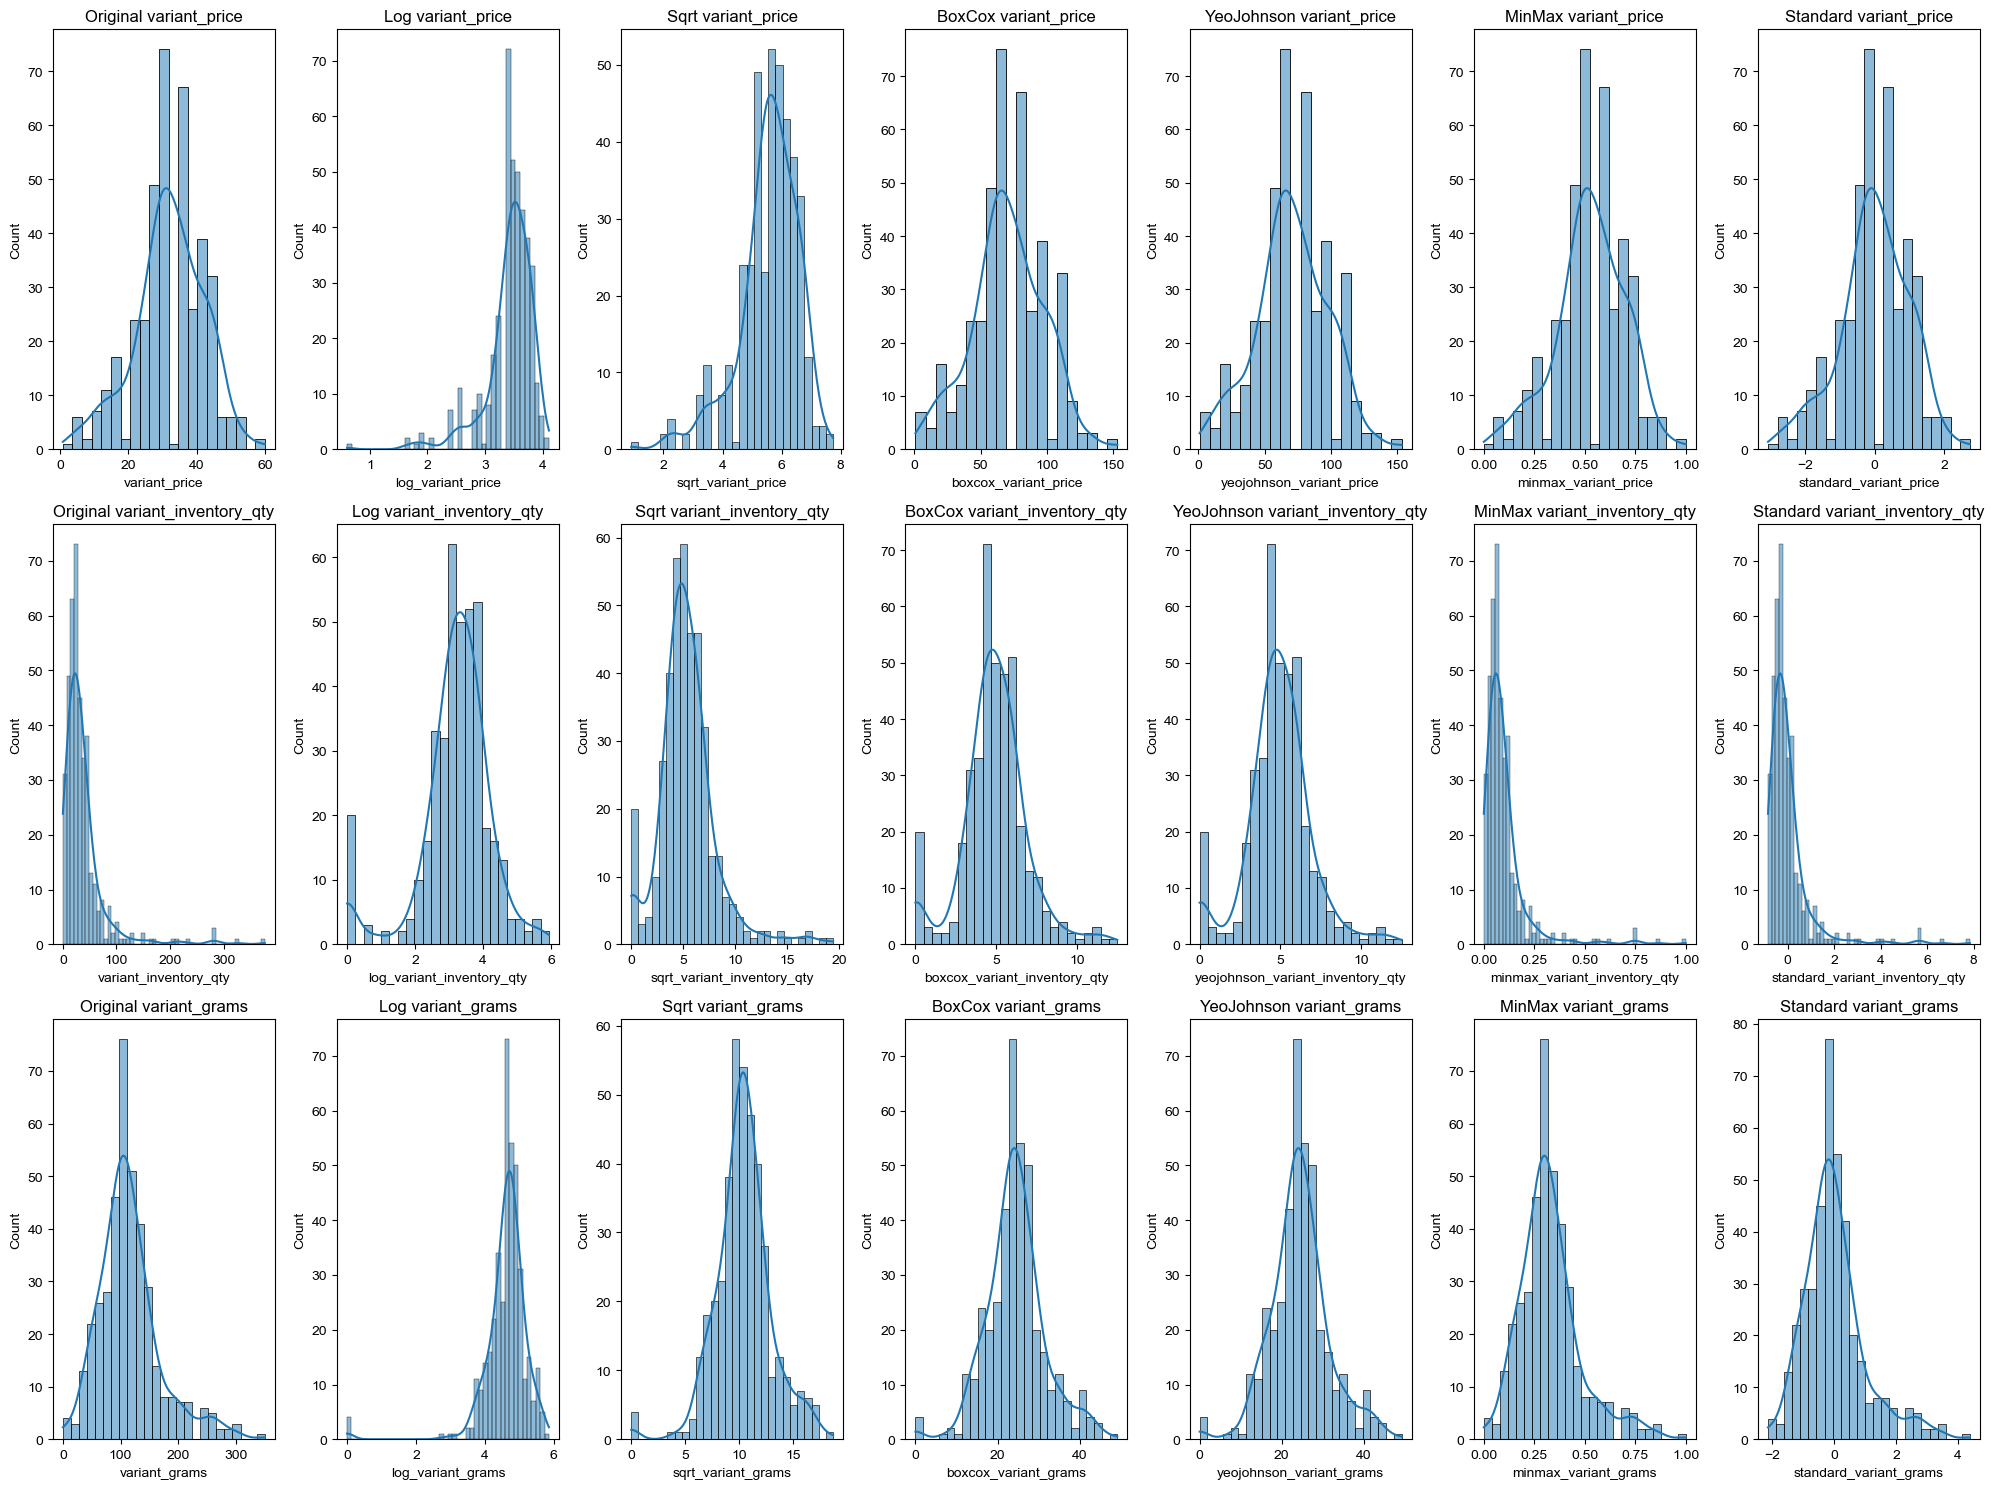

In [33]:
def plot_distributions(df, columns, transformations):
    fig, axes = plt.subplots(len(columns), len(transformations) + 1, figsize=(20, 15))
    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Original {col}')
        for j, (trans_name, trans_col) in enumerate(transformations.items()):
            sns.histplot(df[trans_col[i]], ax=axes[i, j + 1], kde=True)
            axes[i, j + 1].set_title(f'{trans_name} {col}')
    plt.tight_layout()
    plt.show()

# Columns to transform
columns = ['variant_price', 'variant_inventory_qty', 'variant_grams']
transformations = {
    'Log': ['log_variant_price', 'log_variant_inventory_qty', 'log_variant_grams'],
    'Sqrt': ['sqrt_variant_price', 'sqrt_variant_inventory_qty', 'sqrt_variant_grams'],
    'BoxCox': ['boxcox_variant_price', 'boxcox_variant_inventory_qty', 'boxcox_variant_grams'],
    'YeoJohnson': ['yeojohnson_variant_price', 'yeojohnson_variant_inventory_qty', 'yeojohnson_variant_grams'],
    'MinMax': ['minmax_variant_price', 'minmax_variant_inventory_qty', 'minmax_variant_grams'],
    'Standard': ['standard_variant_price', 'standard_variant_inventory_qty', 'standard_variant_grams']
}

# Plot the distributions
plot_distributions(df_products, columns, transformations)

In [34]:
# Calculate skewness and kurtosis for each transformation
results = []

for trans_name, trans_cols in transformations.items():
    for i, col in enumerate(columns):
        skewness = skew(df_products[trans_cols[i]].dropna())
        kurt = kurtosis(df_products[trans_cols[i]].dropna(), fisher=False)
        results.append({
            'Column': col,
            'Transformation': trans_name,
            'Skewness': skewness,
            'Kurtosis': kurt
        })

results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Identify the best transformation based on skewness and kurtosis closest to normal (skewness=0, kurtosis=3)
def best_transformation(results_df):
    best_trans = {}
    for col in columns:
        df = results_df[results_df['Column'] == col]
        df['Skewness_Score'] = np.abs(df['Skewness'])
        df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
        df['Total_Score'] = df['Skewness_Score'] + df['Kurtosis_Score']
        best = df.loc[df['Total_Score'].idxmin()]
        best_trans[col] = best['Transformation']
    return best_trans

best_trans = best_transformation(results_df)
print("\nBest transformation for each column:")
print(best_trans)

                   Column Transformation  Skewness   Kurtosis
0           variant_price            Log -2.229648  11.011316
1   variant_inventory_qty            Log -1.128075   5.644421
2           variant_grams            Log -3.657911  26.720782
3           variant_price           Sqrt -1.143313   5.133860
4   variant_inventory_qty           Sqrt  1.358120   7.878328
5           variant_grams           Sqrt -0.227621   5.384044
6           variant_price         BoxCox -0.058290   3.005467
7   variant_inventory_qty         BoxCox  0.122166   4.906246
8           variant_grams         BoxCox  0.171945   4.460566
9           variant_price     YeoJohnson -0.058290   3.005467
10  variant_inventory_qty     YeoJohnson  0.122166   4.906246
11          variant_grams     YeoJohnson  0.171945   4.460566
12          variant_price         MinMax -0.375785   3.248687
13  variant_inventory_qty         MinMax  4.161052  25.315064
14          variant_grams         MinMax  1.123048   5.100266
15      

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\3923798659.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skewness_Score'] = np.abs(df['Skewness'])
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\3923798659.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\3923798659.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [35]:
# Drop multiple columns
df_products.drop(['variant_price', 'variant_inventory_qty', 'variant_grams', 'log_variant_price', 'log_variant_inventory_qty', 'log_variant_grams', 'sqrt_variant_price', 'sqrt_variant_inventory_qty', 'sqrt_variant_grams', 'boxcox_variant_price', 'yeojohnson_variant_inventory_qty', 'yeojohnson_variant_grams', 'minmax_variant_price', 'minmax_variant_inventory_qty', 'minmax_variant_grams', 'standard_variant_price', 'standard_variant_inventory_qty', 'standard_variant_grams'], axis=1, inplace=True)

## df_products Categorical features

In [36]:
df_products.describe(include='object')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0
count,402,134,133,86,133,133,134,402,398,402,116,130,33,119,119,102
unique,134,134,133,14,23,118,2,15,15,402,113,120,10,3,3,19
top,culotte-amincissante-ventre-plat,Baume réparateur mains et pieds,"<h5><span style=""color: #000000;"" data-mce-sty...",Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging
freq,15,1,1,30,18,5,125,266,118,1,2,4,11,90,62,16


In [37]:
df_products['handle'] = df_products['handle'].apply(lambda x: x.replace('-', ' '))
df_products.describe(include='object')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0
count,402,134,133,86,133,133,134,402,398,402,116,130,33,119,119,102
unique,134,134,133,14,23,118,2,15,15,402,113,120,10,3,3,19
top,culotte amincissante ventre plat,Baume réparateur mains et pieds,"<h5><span style=""color: #000000;"" data-mce-sty...",Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging
freq,15,1,1,30,18,5,125,266,118,1,2,4,11,90,62,16


In [38]:
# Initialize necessary objects
stop_words = set(stopwords.words('french'))  # Assuming French stop words

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the lineitem_name column
df_products['handle'] = df_products['handle'].apply(preprocess_text)

# uppercase all values
df_products['handle'] = df_products['handle'].str.upper()

df_products.describe(include='object')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0
count,402,134,133,86,133,133,134,402,398,402,116,130,33,119,119,102
unique,134,134,133,14,23,118,2,15,15,402,113,120,10,3,3,19
top,CULOTTE AMINCISSANTE VENTRE PLAT,Baume réparateur mains et pieds,"<h5><span style=""color: #000000;"" data-mce-sty...",Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging
freq,15,1,1,30,18,5,125,266,118,1,2,4,11,90,62,16


In [39]:
# freq all values to each title in 2d array 
tf2 = df_products['handle'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

# Rename columns for better readability
tf2.columns = ['words', 'tf']

# Save the results to a CSV file for easier inspection
output_file = 'data/temp_data/handle.csv'
tf2.to_csv(output_file, index=False)

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2778081793.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf2 = df_products['handle'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2778081793.py:2: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tf2 = df_products['handle'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2778081793.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf2 = df_products['handle'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2778081793.py:2: Future

In [40]:
df_products['title'] = df_products['title'].astype(str).fillna('')
df_products['title'] = df_products['title'].str.upper()

# apply value_counts to each title, then sum up the counts
tf3 = df_products['title'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

# Rename columns for better readability
tf3.columns = ['words', 'tf']

# Save the results to a CSV file for inspection
output_file = 'data/temp_data/title.csv'
tf3.to_csv(output_file, index=False)

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\4048808992.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf3 = df_products['title'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\4048808992.py:5: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tf3 = df_products['title'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\4048808992.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf3 = df_products['title'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\4048808992.py:5: FutureWar

In [41]:
# Replace NaN values with an empty string
df_products['body_html'].fillna('', inplace=True)

# Function to remove HTML tags and replace them with spaces
def clean_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    # Get the text and replace tags with spaces
    return ' '.join(soup.stripped_strings)

# Apply the function to the body_html column
df_products['body_html'] = df_products['body_html'].apply(clean_html)


C:\Users\moham\AppData\Local\Temp\ipykernel_9084\356740922.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_products['body_html'].fillna('', inplace=True)


In [42]:
df_products.describe(include='object')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0
count,402,402,402,86,133,133,134,402,398,402,116,130,33,119,119,102
unique,134,135,124,14,23,118,2,15,15,402,113,120,10,3,3,19
top,CULOTTE AMINCISSANTE VENTRE PLAT,NAN,,Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging
freq,15,268,269,30,18,5,125,266,118,1,2,4,11,90,62,16


In [43]:
# Preprocessing function
def preprocess_text(text):
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the lineitem_name column
df_products['body_html'] = df_products['body_html'].apply(preprocess_text)

In [44]:
# uppercase all values
df_products['body_html'] = df_products['body_html'].str.upper()

# Apply value_counts to each title, then sum up the counts
tf4 = df_products['body_html'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

# Rename columns for better readability
tf4.columns = ['words', 'tf']

# Save the results to a CSV file for easier inspection
output_file = 'data/temp_data/body_html.csv'
tf4.to_csv(output_file, index=False)

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2914812322.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf4 = df_products['body_html'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2914812322.py:5: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tf4 = df_products['body_html'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2914812322.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf4 = df_products['body_html'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2914812322.py:

In [45]:
df_products.describe(include='all')

,handle,title,body_html,product_category,type,tags,published,option1_value,option2_value,variant_sku,seo_title,seo_description,google_shopping_product_category,google_shopping_gender,google_shopping_age_group,google_shopping_custom_label_0,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price
count,402,402,402,86,133,133,134,402,398,402,116,130,33,119,119,102,402.000000,402.000000,402.000000
unique,134,135,123,14,23,118,2,15,15,402,113,120,10,3,3,19,NaN,NaN,NaN
top,CULOTTE AMINCISSANTE VENTRE PLAT,NAN,,Vêtements et accessoires > Vêtements > Sous-vê...,Legging,"Accessoires, Actif, Masque, Modèles, Nouveauté...",True,Noir,L/XL,NEG0015,Ceinture amincissante ventre plat femme Lytess...,Innovation Lytess : Découvrez notre gamme d'or...,Apparel & Accessories > Clothing > Underwear &...,female,adultes,legging,NaN,NaN,NaN
freq,15,268,269,30,18,5,125,266,118,1,2,4,11,90,62,16,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.917018,24.422405,70.607975
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.020921,7.153346,27.101204
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.914220
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.972201,20.885664,58.275154
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.819402,24.197651,67.625439
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.933894,28.068766,87.189298


In [46]:
columns_to_check = [
    'handle', 'title', 'body_html', 'product_category', 'type', 'tags', 
    'published', 'seo_title', 'google_shopping_product_category', 'google_shopping_gender', 
    'google_shopping_age_group', 'google_shopping_custom_label_0', 'seo_description'
]
df_products[columns_to_check] = df_products[columns_to_check].fillna('')
# Combine all text columns into a single column
df_products['combined_text'] = df_products[columns_to_check].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Convert combined text to uppercase
df_products['combined_text'] = df_products['combined_text'].str.upper()

# Categories and subcategories
categories = {
    'LEGGING': ['LEGGING'],
    'CULOTTE': ['CULOTTE'],
    'GAINE': ['GAINE'],
    'BODY': ['BODY'],
    'MAILLOT DE BAIN': ['MAILLOT DE BAIN'],
    'PANTACOURT': ['PANTACOURT'],
    'CORSAIRE': ['CORSAIRE'],
    'PANTY': ['PANTY'],
    'SHORTY': ['SHORTY'],
    'COLLANT': ['COLLANT'],
    'STRING': ['STRING'],
    'BRASSIÈRE': ['BRASSIERE'],
    'CARACO': ['CARACO'],
    'BOXER': ['BOXER'],
    'DEBARDEUR': ['DEBARDEUR'],
    'STRING': ['STRING'],
    'GANT': ['GANT'],
    'TOP & TEE SHIRT': ['TOP', 'TEE SHIRT', 'T-SHIRT'],
    'CEINTURE': ['CEINTURE'],
    'MASQUE': ['MASQUE'],
    'ACCESSOIRES': ['ACCESSOIRES'],
    'SOUS-VETEMENTS': ['SOUS', 'UNDERWEAR'],
    'SOCKS': ['SOCKS'],
    'VETEMENT': ['VETEMENTS', 'VÊTEMENTS'],
    'SOIN': ['SOIN'],
    'SANTE': ['SANTE'],
    'HAUT': ['HAUT', 'TOP'],
    'LINGERIE': ['LINGERIE'],
    'MINCEUR NUIT': [
        'LEGGING AMINCISSANT NUIT', 'PANTACOURT AMINCISSANT NUIT', 
        'CORSAIRE AMINCISSANT NUIT', 'PANTY AMINCISSANT NUIT', 
        'ENSEMBLE AMINCISSANT NUIT'
    ],
    'MINCEUR JOUR': [
        'LEGGING AMINCISSANT', 'PANTACOURT AMINCISSANT', 'CORSAIRE AMINCISSANT', 
        'PANTY AMINCISSANT', 'BODY AMINCISSANT', 'COLLANT AMINCISSANT', 
        'TOP & TEE SHIRT AMINCISSANT', 'ENSEMBLE AMINCISSANT'
    ],
    'LINGERIE GAINANTE': [
        'GAINE AMINCISSANTE', 'CULOTTE GAINANTE', 'BODY GAINANT', 
        'LEGGING GAINANT', 'COLLANT GAINANT', 'STRING GAINANT', 
        'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'
    ],
    'ANTI-CELLULITE': [
        'LEGGING ANTICELLULITE', 'PANTACOURT ANTICELLULITE', 'CORSAIRE ANTICELLULITE', 
        'PANTY ANTI CELLULITE', 'ACCESSOIRES ANTICELLULITE'
    ],
    'RAFFERMISSANT BUSTE': [
        'BRASSIÈRE RAFFERMISSANTE', 'TOP ET CARACO RAFFERMISSANT'
    ],
    'SPORT': [
        'LEGGING ET BAS SPORT GAINANT', 'TOP ET BRASSIÈRE SPORT RAFFERMISSANT', 
        'ACCESSOIRE SPORT HYDRATANT ET RÉCUPÉRATION'
    ],
    'GRANDES TAILLES': ['GRANDES TAILLES'],
    'MATERNITE': ['MATERNITE'],
    'HOMME': ['HOMME', 'MALE'],
    'FEMME': ['FEMME', 'FEMALE'],
    'UNISEX': ['UNISEX'],
    'ENFANT': ['ENFANT'], 
    'ADULT': ['ADULT'],

}

## Create binary columns for categories and subcategories
for category, keywords in categories.items():
    regex_pattern = '|'.join([re.escape(keyword) for keyword in keywords])
    df_products[f'{category.replace(" ", "_")}'] = df_products['combined_text'].str.contains(regex_pattern)


In [47]:
# Ensure that if a subcategory is checked, the category is also checked
for category, subcategories in categories.items():
    if len(subcategories) > 1:  # Only for categories with subcategories
        category_col = f'{category.replace(" ", "_")}'
        for subcategory in subcategories:
            subcategory_col = f'{subcategory.replace(" ", "_")}'
            if subcategory_col in df_products.columns:
                df_products[category_col] = df_products[category_col] | df_products[subcategory_col]

In [48]:
# Drop the combined text column as it is no longer needed
df_products.drop(columns=['combined_text', 'handle', 'title', 'body_html', 'product_category', 'type', 'tags', 'seo_title', 'google_shopping_product_category', 'google_shopping_gender', 'google_shopping_age_group', 'google_shopping_custom_label_0'], inplace=True)

# pd.set_option('display.max_columns', None) 
df_products.describe(include='all')

,published,option1_value,option2_value,variant_sku,seo_description,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_NUIT,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,MATERNITE,HOMME,FEMME,UNISEX,ENFANT,ADULT
count,402,402,398,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402
unique,3,15,15,402,121,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2
top,,Noir,L/XL,NEG0015,,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,268,266,118,1,272,NaN,NaN,NaN,347,343,393,374,398,387,382,363,386,395,399,353,396,390,389,395,350,321,387,320,321,385,311,276,257,330,394,402,378,371,397,396,398,400,402,284,302,388,393,283
mean,NaN,NaN,NaN,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.972201,20.885664,58.275154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,4.819402,24.197651,67.625439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.933894,28.068766,87.189298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_products.rename(columns={'option1_value': 'Color'}, inplace=True)
df_products['Size'] = df_products['option2_value'].fillna('')
df_products.drop(columns=['option2_value'], inplace=True)
df_products = pd.get_dummies(df_products, columns=['Color', 'Size'])
df_products.describe(include='all')

,published,variant_sku,seo_description,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_NUIT,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,MATERNITE,HOMME,FEMME,UNISEX,ENFANT,ADULT,Color_Blanc,Color_Bleu,Color_Bleu Marine,Color_Bordeaux,Color_Chair,Color_Corail,Color_Default Title,Color_Gris,Color_Gris&Noir,Color_Ivoire,Color_Noir,Color_Noir-Blanc,Color_Noir-Bleu,Color_Rose,Color_Vert Kaki,Size_,Size_1,Size_2,Size_3,Size_3XL,Size_4,Size_4XL,Size_L,Size_L/XL,Size_M,Size_S,Size_S/M,Size_S/M (XS),Size_TU,Size_XL,Size_XXL
count,402,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402
unique,3,402,121,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,,NEG0015,,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,268,1,272,NaN,NaN,NaN,347,343,393,374,398,387,382,363,386,395,399,353,396,390,389,395,350,321,387,320,321,385,311,276,257,330,394,402,378,371,397,396,398,400,402,284,302,388,393,283,356,396,400,400,370,394,398,400,400,394,266,390,400,394,400,398,394,394,394,387,400,398,384,284,384,394,288,400,384,384,363
mean,NaN,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.972201,20.885664,58.275154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.819402,24.197651,67.625439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.933894,28.068766,87.189298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [49]:
# df_products.to_csv('data/prepared_data/products.csv', index=False)

## df_orders Preparation

In [50]:
# df_orders = pd.read_csv('data/cleaned_data/orders.csv')

In [50]:
df_orders.describe(include='all')

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Lineitem discount,customer_id
count,120422,120422,120422.000000,120422,120422.000000,120422,120422,120422,120422,120422.000000,120422
unique,74314,74284,NaN,1142,NaN,388,1,2,3,NaN,53899
top,#127870,2021-05-07 11:24:34 +0200,NaN,Lot de 2 masques de protection en tissu réutil...,NaN,LOT200001A106/000-BLC-TU,True,True,fulfilled,NaN,'4491371249860
freq,28,28,NaN,1543,NaN,4104,120422,118897,119450,NaN,1978
mean,NaN,NaN,1.290337,NaN,25.156958,NaN,NaN,NaN,NaN,0.074206,NaN
std,NaN,NaN,2.578708,NaN,12.112441,NaN,NaN,NaN,NaN,1.119190,NaN
min,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,1.000000,NaN,16.630000,NaN,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,1.000000,NaN,23.940000,NaN,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,1.000000,NaN,33.250000,NaN,NaN,NaN,NaN,0.000000,NaN


In [51]:
# Renaming columns for clarity
df_orders.rename(columns={
    'Name': 'name',
    'Created at': 'created_at',
    'Lineitem quantity': 'lineitem_quantity',
    'Lineitem name': 'lineitem_name',
    'Lineitem price': 'lineitem_price',
    'Lineitem sku': 'lineitem_sku',
    'Lineitem requires shipping': 'lineitem_requires_shipping',
    'Lineitem taxable': 'lineitem_taxable',
    'Lineitem fulfillment status': 'lineitem_fulfillment_status',
    'Lineitem discount': 'lineitem_discount'
}, inplace=True)

In [53]:
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
#### **************** ####
# Drop name column
# df_orders.drop(['name'], axis=1, inplace=True)

## handling timezone column df_orders['created_at']

In [52]:
# convert 'created_at' to a datetime object and handling the timezone offset
df_orders['created_at'] = pd.to_datetime(df_orders['created_at'], utc=True)

# extracting different columns from the created_at
df_orders['created_year'] = df_orders['created_at'].dt.year
df_orders['created_month'] = df_orders['created_at'].dt.month
df_orders['created_day_of_week'] = df_orders['created_at'].dt.dayofweek # from 0 (monday) to 6
df_orders['created_week_of_year'] = df_orders['created_at'].dt.isocalendar().week
df_orders['created_quarter'] = df_orders['created_at'].dt.quarter

df_orders.describe(include='all')

,name,created_at,lineitem_quantity,lineitem_name,lineitem_price,lineitem_sku,lineitem_requires_shipping,lineitem_taxable,lineitem_fulfillment_status,lineitem_discount,customer_id,created_year,created_month,created_day_of_week,created_week_of_year,created_quarter
count,120422,120422,120422.000000,120422,120422.000000,120422,120422,120422,120422,120422.000000,120422,120422.000000,120422.000000,120422.000000,120422.0,120422.000000
unique,74314,NaN,NaN,1142,NaN,388,1,2,3,NaN,53899,NaN,NaN,NaN,<NA>,NaN
top,#127870,NaN,NaN,Lot de 2 masques de protection en tissu réutil...,NaN,LOT200001A106/000-BLC-TU,True,True,fulfilled,NaN,'4491371249860,NaN,NaN,NaN,<NA>,NaN
freq,28,NaN,NaN,1543,NaN,4104,120422,118897,119450,NaN,1978,NaN,NaN,NaN,<NA>,NaN
mean,NaN,2021-12-13 17:56:40.533067008+00:00,1.290337,NaN,25.156958,NaN,NaN,NaN,NaN,0.074206,NaN,2021.356853,7.753791,3.229136,31.586919,2.835852
min,NaN,2020-08-24 13:30:21+00:00,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,2020.000000,1.000000,0.000000,1.0,1.000000
25%,NaN,2020-12-07 01:38:27.500000+00:00,1.000000,NaN,16.630000,NaN,NaN,NaN,NaN,0.000000,NaN,2020.000000,3.000000,1.000000,13.0,1.000000
50%,NaN,2021-07-19 07:40:09+00:00,1.000000,NaN,23.940000,NaN,NaN,NaN,NaN,0.000000,NaN,2021.000000,9.000000,3.000000,36.0,3.000000
75%,NaN,2023-01-14 20:05:59+00:00,1.000000,NaN,33.250000,NaN,NaN,NaN,NaN,0.000000,NaN,2023.000000,12.000000,6.000000,49.0,4.000000
max,NaN,2024-02-19 15:05:14+00:00,500.000000,NaN,69.900000,NaN,NaN,NaN,NaN,85.800000,NaN,2024.000000,12.000000,6.000000,53.0,4.000000


In [53]:
# Drop created_at column
df_orders.drop(columns=['created_at'], inplace=True)

In [54]:
# Drop irrelevant columns
df_orders.drop(columns=['lineitem_requires_shipping', 'lineitem_taxable'], inplace=True)

## df_orders['lineitem_fulfillment_status'] one-hot encoding

In [55]:
# One-hot encode 'lineitem_fulfillment_status'
df_orders = pd.get_dummies(df_orders, columns=['lineitem_fulfillment_status'], prefix='fulfillment')

In [56]:
df_orders.describe(include='all')

,name,lineitem_quantity,lineitem_name,lineitem_price,lineitem_sku,lineitem_discount,customer_id,created_year,created_month,created_day_of_week,created_week_of_year,created_quarter,fulfillment_fulfilled,fulfillment_pending,fulfillment_restocked
count,120422,120422.000000,120422,120422.000000,120422,120422.000000,120422,120422.000000,120422.000000,120422.000000,120422.0,120422.000000,120422,120422,120422
unique,74314,NaN,1142,NaN,388,NaN,53899,NaN,NaN,NaN,<NA>,NaN,2,2,2
top,#127870,NaN,Lot de 2 masques de protection en tissu réutil...,NaN,LOT200001A106/000-BLC-TU,NaN,'4491371249860,NaN,NaN,NaN,<NA>,NaN,True,False,False
freq,28,NaN,1543,NaN,4104,NaN,1978,NaN,NaN,NaN,<NA>,NaN,119450,119451,120421
mean,NaN,1.290337,NaN,25.156958,NaN,0.074206,NaN,2021.356853,7.753791,3.229136,31.586919,2.835852,NaN,NaN,NaN
std,NaN,2.578708,NaN,12.112441,NaN,1.119190,NaN,1.287382,4.277111,2.379277,18.319871,1.260085,NaN,NaN,NaN
min,NaN,1.000000,NaN,0.000000,NaN,0.000000,NaN,2020.000000,1.000000,0.000000,1.0,1.000000,NaN,NaN,NaN
25%,NaN,1.000000,NaN,16.630000,NaN,0.000000,NaN,2020.000000,3.000000,1.000000,13.0,1.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,23.940000,NaN,0.000000,NaN,2021.000000,9.000000,3.000000,36.0,3.000000,NaN,NaN,NaN
75%,NaN,1.000000,NaN,33.250000,NaN,0.000000,NaN,2023.000000,12.000000,6.000000,49.0,4.000000,NaN,NaN,NaN


### Lineitem_name got descriptions like categories color and size

In [57]:
# Specify the column you want to analyze
column_order_lineitem_name = 'lineitem_name'

# Get the count of each unique value
value_counts_order_lineitem_name = df_orders[column_order_lineitem_name].value_counts(dropna=False)

# Create a new DataFrame to store the results
df_value_counts = pd.DataFrame(value_counts_order_lineitem_name).reset_index()
df_value_counts.columns = ['lineitem_name', 'count']

# Save the results to a CSV file for easier inspection
output_file = 'order_lineitem_name.csv'
df_value_counts.to_csv(output_file, index=False)

In [58]:
color_mapping = {
    'Moka': ['Moka'],
    'Blanc': ['Blanc', 'Bianca', 'Bianco', 'Bianche', 'Blanc&Noir', 'Bianco e Nero'],
    'Corail': ['Corail', 'Corallo'],
    'Chair': ['Chair'],
    'Noir': ['Noir', 'Nera', 'Nero', 'Neri', 'Note-Nero', 'Blanc&Noir', 'Bianco e Nero'],
    'Bleu': ['Bleu', 'Blu', 'Note - Blu'],
    'Bleu Marine': ['Bleu Marine'],
    'Bordeaux': ['Bordeaux'],
    'Vert Kaki': ['Vert Kaki'],
    'Rose': ['Rose'],
    'Gris': ['Gris', 'Notte Grigio'],
    'Gris&Noir': ['Gris&Noir', 'Noir&Gris', 'nero e grigia'],
    'Ivoire': ['Ivoire', 'avorio'],
    'Beige': ['Beige'],
    'Peau': ['Peau'],
    'Noir-Blanc': ['Noir-Blanc', 'Noir et blanc', 'Blanc et Noir']
}

# Function that checks if a lineitem_name contains any color and then updates the respective column
def check_and_update_color(row, color_mapping):
    lineitem_name = row['lineitem_name'].upper()
    sku = row['lineitem_sku']
    for color, variations in color_mapping.items():
        for variation in variations:
            if variation.upper() in lineitem_name:
                color_col = f'Color_{color}'
                df_products.loc[df_products['variant_sku'] == sku, color_col] = True
    return row

# Apply the function to each row in df_orders
df_orders = df_orders.apply(check_and_update_color, color_mapping=color_mapping, axis=1)
df_orders.describe(include='all')

,name,lineitem_quantity,lineitem_name,lineitem_price,lineitem_sku,lineitem_discount,customer_id,created_year,created_month,created_day_of_week,created_week_of_year,created_quarter,fulfillment_fulfilled,fulfillment_pending,fulfillment_restocked
count,120422,120422.000000,120422,120422.000000,120422,120422.000000,120422,120422.000000,120422.000000,120422.000000,120422.000000,120422.000000,120422,120422,120422
unique,74314,NaN,1142,NaN,388,NaN,53899,NaN,NaN,NaN,NaN,NaN,2,2,2
top,#127870,NaN,Lot de 2 masques de protection en tissu réutil...,NaN,LOT200001A106/000-BLC-TU,NaN,'4491371249860,NaN,NaN,NaN,NaN,NaN,True,False,False
freq,28,NaN,1543,NaN,4104,NaN,1978,NaN,NaN,NaN,NaN,NaN,119450,119451,120421
mean,NaN,1.290337,NaN,25.156958,NaN,0.074206,NaN,2021.356853,7.753791,3.229136,31.586919,2.835852,NaN,NaN,NaN
std,NaN,2.578708,NaN,12.112441,NaN,1.119190,NaN,1.287382,4.277111,2.379277,18.319871,1.260085,NaN,NaN,NaN
min,NaN,1.000000,NaN,0.000000,NaN,0.000000,NaN,2020.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN
25%,NaN,1.000000,NaN,16.630000,NaN,0.000000,NaN,2020.000000,3.000000,1.000000,13.000000,1.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,23.940000,NaN,0.000000,NaN,2021.000000,9.000000,3.000000,36.000000,3.000000,NaN,NaN,NaN
75%,NaN,1.000000,NaN,33.250000,NaN,0.000000,NaN,2023.000000,12.000000,6.000000,49.000000,4.000000,NaN,NaN,NaN


In [59]:
df_products.describe(include='all')

,published,variant_sku,seo_description,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_NUIT,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,MATERNITE,HOMME,FEMME,UNISEX,ENFANT,ADULT,Color_Blanc,Color_Bleu,Color_Bleu Marine,Color_Bordeaux,Color_Chair,Color_Corail,Color_Default Title,Color_Gris,Color_Gris&Noir,Color_Ivoire,Color_Noir,Color_Noir-Blanc,Color_Noir-Bleu,Color_Rose,Color_Vert Kaki,Size_,Size_1,Size_2,Size_3,Size_3XL,Size_4,Size_4XL,Size_L,Size_L/XL,Size_M,Size_S,Size_S/M,Size_S/M (XS),Size_TU,Size_XL,Size_XXL,Color_Beige,Color_Peau,Color_Moka
count,402,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,18,2,3
unique,3,402,121,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1
top,,NEG0015,,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
freq,268,1,272,NaN,NaN,NaN,347,343,393,374,398,387,382,363,386,395,399,353,396,390,389,395,350,321,387,320,321,385,311,276,257,330,394,402,378,371,397,396,398,400,402,284,302,388,393,283,344,392,400,400,370,394,398,395,398,394,285,390,400,394,400,398,394,394,394,387,400,398,384,284,384,394,288,400,384,384,363,18,2,3
mean,NaN,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.972201,20.885664,58.275154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.819402,24.197651,67.625439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.933894,28.068766,87.189298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [60]:
df_products['Color_Beige'].fillna(False, inplace=True)
df_products['Color_Peau'].fillna(False, inplace=True)
df_products['Color_Moka'].fillna(False, inplace=True)

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\3835853276.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_products['Color_Beige'].fillna(False, inplace=True)
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\3835853276.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_products['Color_Beige'].fillna

In [61]:
df_products.drop(columns=['Size_'], inplace=True)
df_products.describe(include='all')

,published,variant_sku,seo_description,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_NUIT,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,MATERNITE,HOMME,FEMME,UNISEX,ENFANT,ADULT,Color_Blanc,Color_Bleu,Color_Bleu Marine,Color_Bordeaux,Color_Chair,Color_Corail,Color_Default Title,Color_Gris,Color_Gris&Noir,Color_Ivoire,Color_Noir,Color_Noir-Blanc,Color_Noir-Bleu,Color_Rose,Color_Vert Kaki,Size_1,Size_2,Size_3,Size_3XL,Size_4,Size_4XL,Size_L,Size_L/XL,Size_M,Size_S,Size_S/M,Size_S/M (XS),Size_TU,Size_XL,Size_XXL,Color_Beige,Color_Peau,Color_Moka
count,402,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402
unique,3,402,121,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,,NEG0015,,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,268,1,272,NaN,NaN,NaN,347,343,393,374,398,387,382,363,386,395,399,353,396,390,389,395,350,321,387,320,321,385,311,276,257,330,394,402,378,371,397,396,398,400,402,284,302,388,393,283,344,392,400,400,370,394,398,395,398,394,285,390,400,394,400,394,394,394,387,400,398,384,284,384,394,288,400,384,384,363,384,400,399
mean,NaN,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.972201,20.885664,58.275154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.819402,24.197651,67.625439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.933894,28.068766,87.189298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [62]:
# Function that updates df_products based on df_orders lineitem_name
def update_categories(row):
    lineitem_name = row['lineitem_name']
    lineitem_sku = row['lineitem_sku']
    
    # based on id find the corresponding product in df_products
    product_index = df_products[df_products['variant_sku'] == lineitem_sku].index
    
    if not product_index.empty:
        for category, subcategories in categories.items():
            if any(subcat in lineitem_name for subcat in subcategories):
                df_products.at[product_index[0], category] = True
                for subcategory in subcategories:
                    df_products.at[product_index[0], subcategory] = True

df_orders['lineitem_name'] = df_orders['lineitem_name'].str.upper()
# Apply the function to each row in df_orders
df_orders.apply(update_categories, axis=1)

# Ensure that if a subcategory is checked, the category is also checked
for category, subcategories in categories.items():
    if len(subcategories) > 1:  # checks that categories have subcategories
        category_col = f'{category.replace(" ", "_")}'
        for subcategory in subcategories:
            subcategory_col = f'{subcategory.replace(" ", "_")}'
            if subcategory_col in df_products.columns:
                df_products[category_col] = df_products[category_col] | df_products[subcategory_col]

df_products.describe(include='all')

,published,variant_sku,seo_description,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_NUIT,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,MATERNITE,HOMME,FEMME,UNISEX,ENFANT,ADULT,Color_Blanc,Color_Bleu,Color_Bleu Marine,Color_Bordeaux,Color_Chair,Color_Corail,Color_Default Title,Color_Gris,Color_Gris&Noir,Color_Ivoire,Color_Noir,Color_Noir-Blanc,Color_Noir-Bleu,Color_Rose,Color_Vert Kaki,Size_1,Size_2,Size_3,Size_3XL,Size_4,Size_4XL,Size_L,Size_L/XL,Size_M,Size_S,Size_S/M,Size_S/M (XS),Size_TU,Size_XL,Size_XXL,Color_Beige,Color_Peau,Color_Moka,TOP & TEE SHIRT,TOP,TEE SHIRT,T-SHIRT,LINGERIE GAINANTE,GAINE AMINCISSANTE,CULOTTE GAINANTE,BODY GAINANT,LEGGING GAINANT,COLLANT GAINANT,STRING GAINANT,MAILLOT DE BAIN GAINANT,PANTY PUSH UP GAINANT,TEE-SHIRT GAINANT,MAILLOT DE BAIN,BRASSIERE,MALE,FEMALE,MINCEUR JOUR,LEGGING AMINCISSANT,PANTACOURT AMINCISSANT,CORSAIRE AMINCISSANT,PANTY AMINCISSANT,BODY AMINCISSANT,COLLANT AMINCISSANT,TOP & TEE SHIRT AMINCISSANT,ENSEMBLE AMINCISSANT,RAFFERMISSANT BUSTE,BRASSIÈRE RAFFERMISSANTE,TOP ET CARACO RAFFERMISSANT
count,402,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,40,47,40,40,16,16,16,16,16,16,16,16,16,16,14,27,27,8,1,1,1,1,1,1,1,1,1,7,7,7
unique,3,402,121,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,,NEG0015,,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
freq,268,1,272,NaN,NaN,NaN,347,343,393,374,398,387,380,360,386,395,399,353,396,390,389,395,341,320,387,320,321,385,311,275,248,317,394,402,378,371,397,396,398,400,402,275,295,388,393,283,344,392,400,400,370,394,398,395,398,394,285,390,400,394,400,394,394,394,387,400,398,384,284,384,394,288,400,384,384,363,384,400,399,40,47,40,40,16,16,16,16,16,16,16,16,16,16,14,27,27,8,1,1,1,1,1,1,1,1,1,7,7,7
mean,NaN,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN

In [63]:
df_products.drop(columns=['seo_description'], inplace=True)

In [64]:
# Fill null values in all columns with False
df_products = df_products.fillna(False)

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\1042323429.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_products = df_products.fillna(False)


In [65]:
# Drop columns with only a single unique value
df_products = df_products.loc[:, df_products.nunique() > 1]
# Function to find duplicate columns
def find_duplicate_columns(df):
    duplicate_columns = {}
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if df[columns[i]].equals(df[columns[j]]):
                if columns[i] in duplicate_columns:
                    duplicate_columns[columns[i]].append(columns[j])
                else:
                    duplicate_columns[columns[i]] = [columns[j]]
    return duplicate_columns

# Find and print duplicate columns
duplicate_columns = find_duplicate_columns(df_products)
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: {'TOP & TEE SHIRT': ['TEE SHIRT', 'T-SHIRT'], 'TEE SHIRT': ['T-SHIRT'], 'LINGERIE GAINANTE': ['GAINE AMINCISSANTE', 'CULOTTE GAINANTE', 'BODY GAINANT', 'LEGGING GAINANT', 'COLLANT GAINANT', 'STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'], 'GAINE AMINCISSANTE': ['CULOTTE GAINANTE', 'BODY GAINANT', 'LEGGING GAINANT', 'COLLANT GAINANT', 'STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'], 'CULOTTE GAINANTE': ['BODY GAINANT', 'LEGGING GAINANT', 'COLLANT GAINANT', 'STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'], 'BODY GAINANT': ['LEGGING GAINANT', 'COLLANT GAINANT', 'STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'], 'LEGGING GAINANT': ['COLLANT GAINANT', 'STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 'PANTY PUSH UP GAINANT', 'TEE-SHIRT GAINANT'], 'COLLANT GAINANT': ['STRING GAINANT', 'MAILLOT DE BAIN GAINANT', 

In [66]:
# drop duplicate columns
for key, value in duplicate_columns.items():
    # Check if all the columns in value list exist in the DataFrame
    for column in value:
        if column in df_products.columns:
            df_products.drop(columns=column, inplace=True)
df_products.describe(include='all')

,published,variant_sku,boxcox_variant_inventory_qty,boxcox_variant_grams,yeojohnson_variant_price,LEGGING,CULOTTE,GAINE,BODY,MAILLOT_DE_BAIN,PANTACOURT,CORSAIRE,PANTY,SHORTY,COLLANT,STRING,BRASSIÈRE,CARACO,BOXER,DEBARDEUR,GANT,TOP_&_TEE_SHIRT,CEINTURE,MASQUE,ACCESSOIRES,SOUS-VETEMENTS,SOCKS,VETEMENT,SOIN,SANTE,HAUT,LINGERIE,MINCEUR_JOUR,LINGERIE_GAINANTE,ANTI-CELLULITE,RAFFERMISSANT_BUSTE,SPORT,GRANDES_TAILLES,HOMME,FEMME,UNISEX,ENFANT,ADULT,Color_Blanc,Color_Bleu,Color_Bleu Marine,Color_Bordeaux,Color_Chair,Color_Corail,Color_Default Title,Color_Gris,Color_Gris&Noir,Color_Ivoire,Color_Noir,Color_Noir-Blanc,Color_Noir-Bleu,Color_Rose,Color_Vert Kaki,Size_1,Size_2,Size_3,Size_3XL,Size_4,Size_4XL,Size_L,Size_L/XL,Size_M,Size_S,Size_S/M,Size_S/M (XS),Size_TU,Size_XL,Size_XXL,Color_Beige,Color_Peau,Color_Moka,TOP & TEE SHIRT,TOP,LINGERIE GAINANTE,MAILLOT DE BAIN,BRASSIERE,MALE,FEMALE,MINCEUR JOUR,RAFFERMISSANT BUSTE
count,402,402,402.000000,402.000000,402.000000,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402,402
unique,3,402,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,,NEG0015,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,268,1,NaN,NaN,NaN,347,343,393,374,398,387,380,360,386,395,399,353,396,390,389,395,341,320,387,320,321,385,311,275,248,317,394,378,371,397,396,398,400,275,295,388,393,283,344,392,400,400,370,394,398,395,398,394,285,390,400,394,400,394,394,394,387,400,398,384,284,384,394,288,400,384,384,363,384,400,399,362,355,386,388,375,375,394,401,395
mean,NaN,NaN,4.917018,24.422405,70.607975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,2.020921,7.153346,27.101204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,0.000000,0.914220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.972201,20.885664,58.275154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.819402,24.197651,67.625439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [67]:
# rechecking
duplicate_columns = find_duplicate_columns(df_products)
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: {}


In [68]:
df_orders.drop(columns='lineitem_name', inplace=True)
df_orders.describe(include='all')

,name,lineitem_quantity,lineitem_price,lineitem_sku,lineitem_discount,customer_id,created_year,created_month,created_day_of_week,created_week_of_year,created_quarter,fulfillment_fulfilled,fulfillment_pending,fulfillment_restocked
count,120422,120422.000000,120422.000000,120422,120422.000000,120422,120422.000000,120422.000000,120422.000000,120422.000000,120422.000000,120422,120422,120422
unique,74314,NaN,NaN,388,NaN,53899,NaN,NaN,NaN,NaN,NaN,2,2,2
top,#127870,NaN,NaN,LOT200001A106/000-BLC-TU,NaN,'4491371249860,NaN,NaN,NaN,NaN,NaN,True,False,False
freq,28,NaN,NaN,4104,NaN,1978,NaN,NaN,NaN,NaN,NaN,119450,119451,120421
mean,NaN,1.290337,25.156958,NaN,0.074206,NaN,2021.356853,7.753791,3.229136,31.586919,2.835852,NaN,NaN,NaN
std,NaN,2.578708,12.112441,NaN,1.119190,NaN,1.287382,4.277111,2.379277,18.319871,1.260085,NaN,NaN,NaN
min,NaN,1.000000,0.000000,NaN,0.000000,NaN,2020.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN
25%,NaN,1.000000,16.630000,NaN,0.000000,NaN,2020.000000,3.000000,1.000000,13.000000,1.000000,NaN,NaN,NaN
50%,NaN,1.000000,23.940000,NaN,0.000000,NaN,2021.000000,9.000000,3.000000,36.000000,3.000000,NaN,NaN,NaN
75%,NaN,1.000000,33.250000,NaN,0.000000,NaN,2023.000000,12.000000,6.000000,49.000000,4.000000,NaN,NaN,NaN


In [69]:
df_orders.drop(columns='name', inplace=True)

## Numerical columns in df_orders

In [70]:
#adding new column
# calculate the total spend per line item
df_orders['total_spend_per_order'] = df_orders['lineitem_quantity'] * df_orders['lineitem_price']

In [71]:
print("Skewness of lineitem_price:", skew(df_orders['lineitem_price']))
print("Kurtosis of lineitem_price:", kurtosis(df_orders['lineitem_price']))

print("Skewness of lineitem_discount:", skew(df_orders['lineitem_discount']))
print("Kurtosis of lineitem_discount:", kurtosis(df_orders['lineitem_discount']))

print("Skewness of total_spend_per_order:", skew(df_orders['total_spend_per_order']))
print("Kurtosis of total_spend_per_order:", kurtosis(df_orders['total_spend_per_order']))

Skewness of lineitem_price: 0.5024112254112961
Kurtosis of lineitem_price: 0.03847878347554623
Skewness of lineitem_discount: 25.35596005990362
Kurtosis of lineitem_discount: 1014.2528886855702
Skewness of total_spend_per_order: 57.16359102351043
Kurtosis of total_spend_per_order: 7182.4773458148065


In [72]:
# Log Transformation
df_orders['log_lineitem_price'] = np.log1p(df_orders['lineitem_price'])
df_orders['log_lineitem_discount'] = np.log1p(df_orders['lineitem_discount'])
df_orders['log_total_spend_per_order'] = np.log1p(df_orders['total_spend_per_order'])

In [73]:
# Square Root Transformation
df_orders['sqrt_lineitem_price'] = np.sqrt(df_orders['lineitem_price'])
df_orders['sqrt_lineitem_discount'] = np.sqrt(df_orders['lineitem_discount'])
df_orders['sqrt_total_spend_per_order'] = np.sqrt(df_orders['total_spend_per_order'])

In [74]:
# Box-Cox Transformation (only for strictly positive values)
df_orders['boxcox_lineitem_price'], _ = stats.boxcox(df_orders['lineitem_price'] + 1)
df_orders['boxcox_lineitem_discount'], _ = stats.boxcox(df_orders['lineitem_discount'] + 1)
df_orders['boxcox_total_spend_per_order'], _ = stats.boxcox(df_orders['total_spend_per_order'] + 1)

# Yeo-Johnson Transformation (can handle zero and negative values)
df_orders['yeojohnson_lineitem_price'], _ = stats.yeojohnson(df_orders['lineitem_price'])
df_orders['yeojohnson_lineitem_discount'], _ = stats.yeojohnson(df_orders['lineitem_discount'])
df_orders['yeojohnson_total_spend_per_order'], _ = stats.yeojohnson(df_orders['total_spend_per_order'])

In [75]:
# Min-Max Normalization
scaler = MinMaxScaler()
df_orders['minmax_lineitem_price'] = scaler.fit_transform(df_orders[['lineitem_price']])
df_orders['minmax_lineitem_discount'] = scaler.fit_transform(df_orders[['lineitem_discount']])
df_orders['minmax_total_spend_per_order'] = scaler.fit_transform(df_orders[['total_spend_per_order']])

# Standardization
scaler = StandardScaler()
df_orders['standard_lineitem_price'] = scaler.fit_transform(df_orders[['lineitem_price']])
df_orders['standard_lineitem_discount'] = scaler.fit_transform(df_orders[['lineitem_discount']])
df_orders['standard_total_spend_per_order'] = scaler.fit_transform(df_orders[['total_spend_per_order']])


c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\moham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

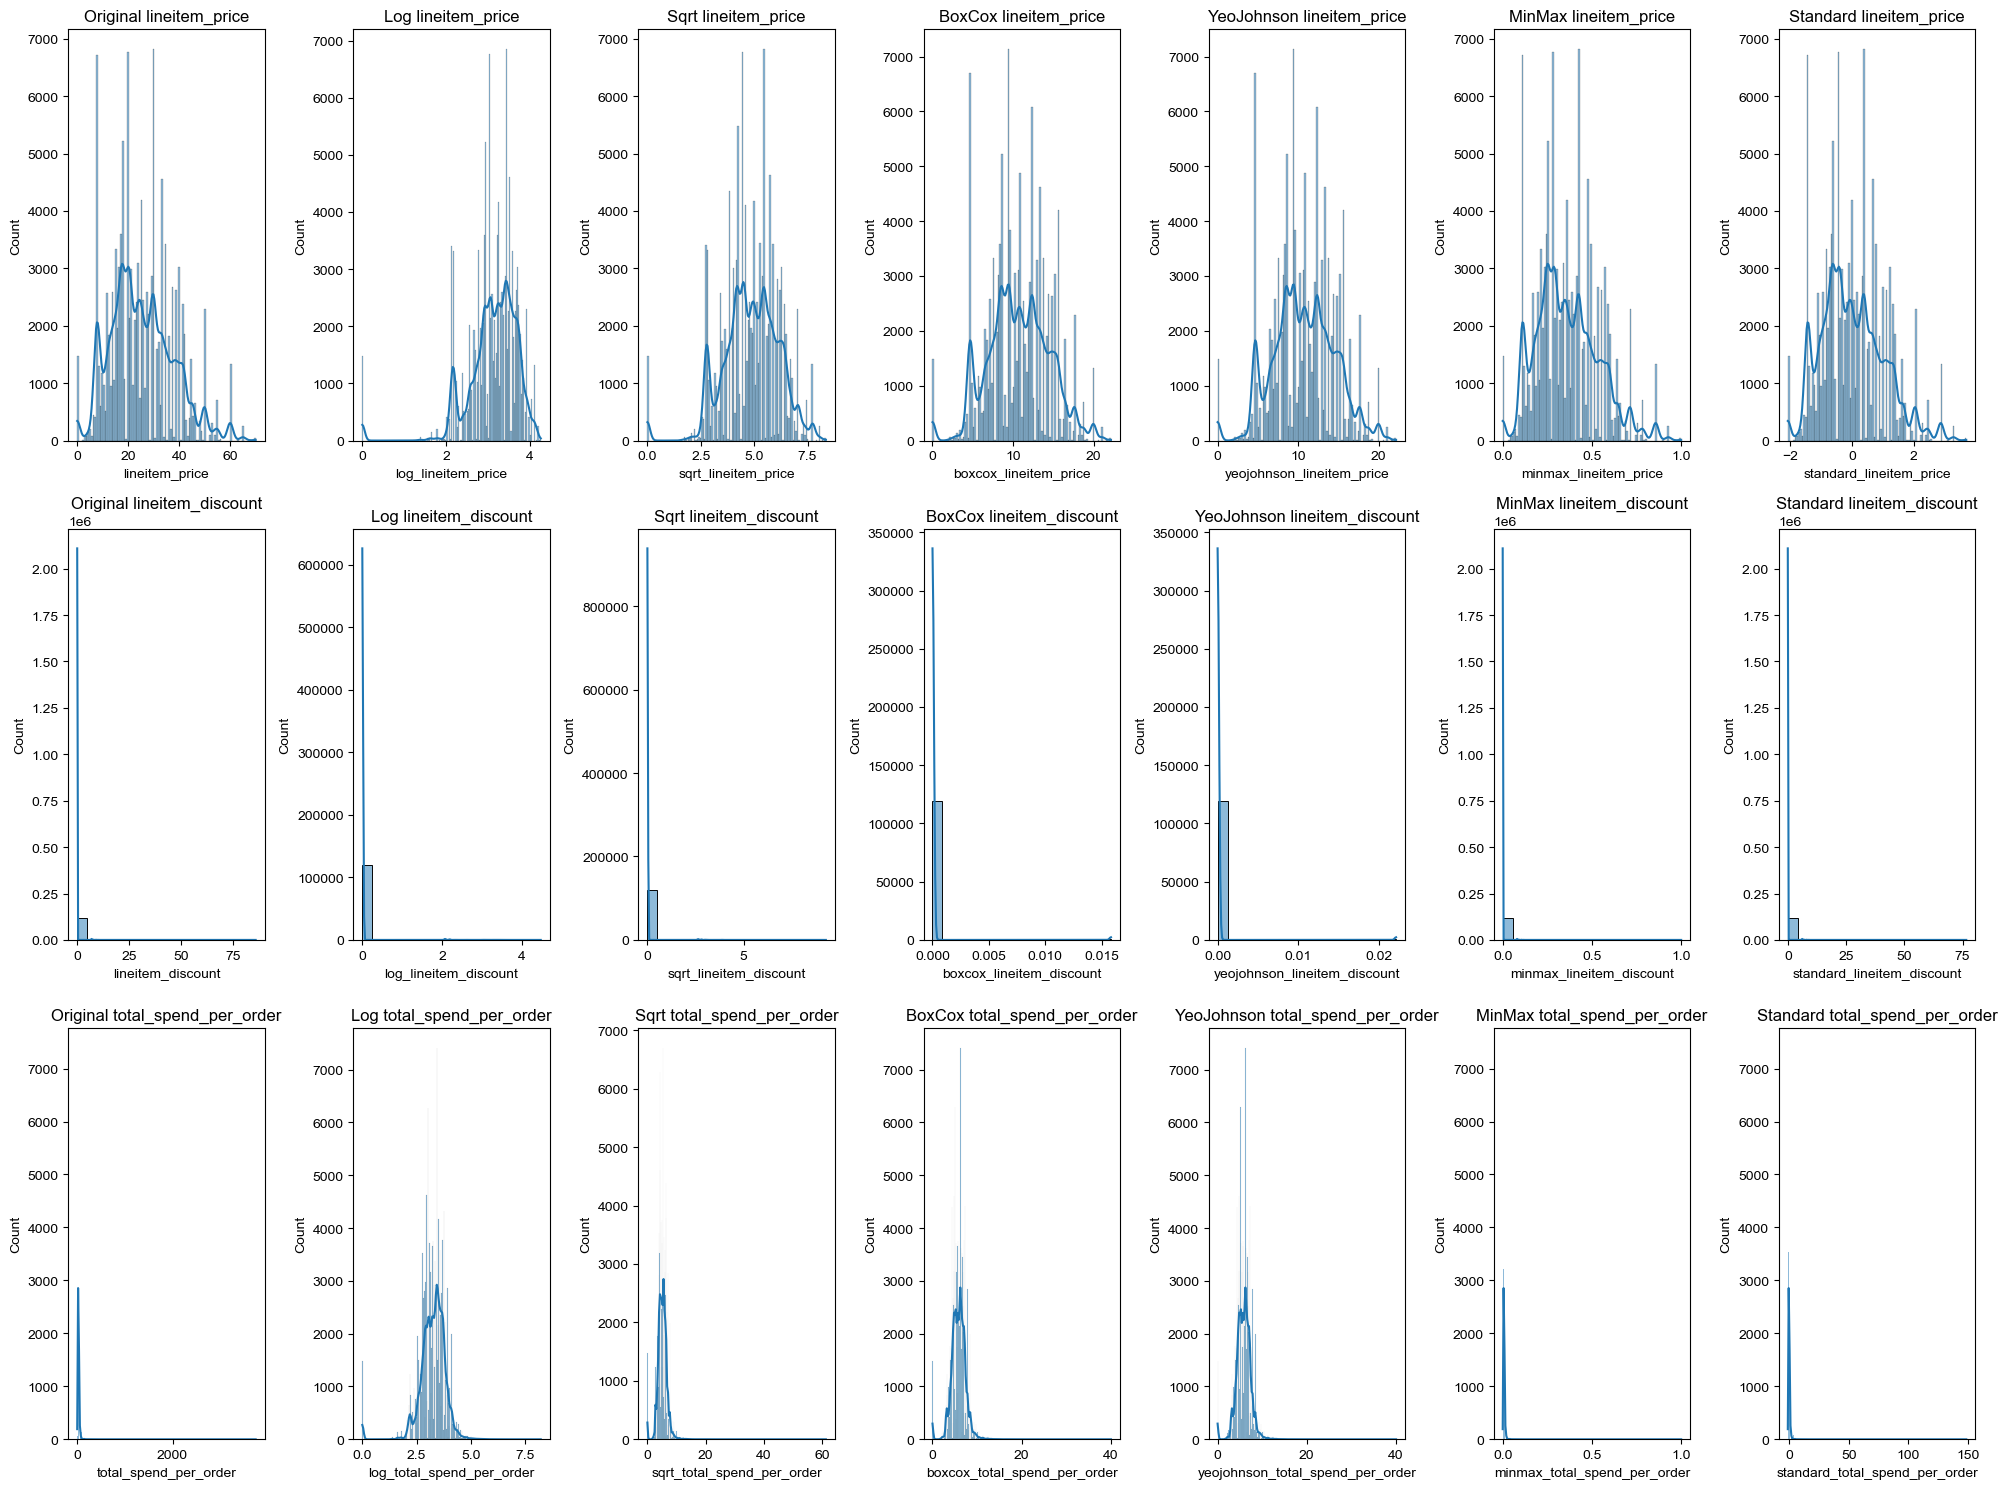

In [76]:
def plot_distributions(df, columns, transformations):
    fig, axes = plt.subplots(len(columns), len(transformations) + 1, figsize=(20, 15))
    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Original {col}')
        for j, (trans_name, trans_col) in enumerate(transformations.items()):
            sns.histplot(df[trans_col[i]], ax=axes[i, j + 1], kde=True)
            axes[i, j + 1].set_title(f'{trans_name} {col}')
    plt.tight_layout()
    plt.show()

# Columns to transform
columns = ['lineitem_price', 'lineitem_discount', 'total_spend_per_order']
transformations = {
    'Log': ['log_lineitem_price', 'log_lineitem_discount', 'log_total_spend_per_order'],
    'Sqrt': ['sqrt_lineitem_price', 'sqrt_lineitem_discount', 'sqrt_total_spend_per_order'],
    'BoxCox': ['boxcox_lineitem_price', 'boxcox_lineitem_discount', 'boxcox_total_spend_per_order'],
    'YeoJohnson': ['yeojohnson_lineitem_price', 'yeojohnson_lineitem_discount', 'yeojohnson_total_spend_per_order'],
    'MinMax': ['minmax_lineitem_price', 'minmax_lineitem_discount', 'minmax_total_spend_per_order'],
    'Standard': ['standard_lineitem_price', 'standard_lineitem_discount', 'standard_total_spend_per_order']
}

# Plot the distributions
plot_distributions(df_orders, columns, transformations)

In [77]:
# Calculate skewness and kurtosis for each transformation
results = []

for trans_name, trans_cols in transformations.items():
    for i, col in enumerate(columns):
        skewness = skew(df_orders[trans_cols[i]].dropna())
        kurt = kurtosis(df_orders[trans_cols[i]].dropna(), fisher=False)
        results.append({
            'Column': col,
            'Transformation': trans_name,
            'Skewness': skewness,
            'Kurtosis': kurt
        })

results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Identify the best transformation based on skewness and kurtosis closest to normal (skewness=0, kurtosis=3)
def best_transformation(results_df):
    best_trans = {}
    for col in columns:
        df = results_df[results_df['Column'] == col]
        df['Skewness_Score'] = np.abs(df['Skewness'])
        df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
        df['Total_Score'] = df['Skewness_Score'] + df['Kurtosis_Score']
        best = df.loc[df['Total_Score'].idxmin()]
        best_trans[col] = best['Transformation']
    return best_trans

best_trans = best_transformation(results_df)
print("\nBest transformation for each column:")
print(best_trans)

                   Column Transformation   Skewness     Kurtosis
0          lineitem_price            Log  -1.892791    10.326294
1       lineitem_discount            Log  12.872354   174.967870
2   total_spend_per_order            Log  -1.729997    11.716852
3          lineitem_price           Sqrt  -0.499276     4.126551
4       lineitem_discount           Sqrt  14.090693   226.840462
5   total_spend_per_order           Sqrt   1.853243    46.264229
6          lineitem_price         BoxCox  -0.007754     2.931795
7       lineitem_discount         BoxCox  12.054449   146.309744
8   total_spend_per_order         BoxCox   0.350519    12.066342
9          lineitem_price     YeoJohnson  -0.007754     2.931795
10      lineitem_discount     YeoJohnson  12.054449   146.309744
11  total_spend_per_order     YeoJohnson   0.350519    12.066343
12         lineitem_price         MinMax   0.502411     3.038479
13      lineitem_discount         MinMax  25.355960  1017.252889
14  total_spend_per_order

C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2876340906.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skewness_Score'] = np.abs(df['Skewness'])
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2876340906.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kurtosis_Score'] = np.abs(df['Kurtosis'] - 3)
C:\Users\moham\AppData\Local\Temp\ipykernel_9084\2876340906.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [78]:
df_orders.drop(['lineitem_price', 'lineitem_discount', 'total_spend_per_order', 'log_lineitem_price', 'log_lineitem_discount', 'log_total_spend_per_order', 'sqrt_lineitem_discount', 'sqrt_total_spend_per_order', 'sqrt_lineitem_price', 'yeojohnson_lineitem_price', 'yeojohnson_lineitem_discount', 'yeojohnson_total_spend_per_order', 'minmax_lineitem_price', 'minmax_lineitem_discount', 'minmax_total_spend_per_order', 'standard_lineitem_price', 'standard_lineitem_discount', 'standard_total_spend_per_order'], axis=1, inplace=True)
df_orders.describe(include='all')

,lineitem_quantity,lineitem_sku,customer_id,created_year,created_month,created_day_of_week,created_week_of_year,created_quarter,fulfillment_fulfilled,fulfillment_pending,fulfillment_restocked,boxcox_lineitem_price,boxcox_lineitem_discount,boxcox_total_spend_per_order
count,120422.000000,120422,120422,120422.000000,120422.000000,120422.000000,120422.000000,120422.000000,120422,120422,120422,120422.000000,120422.000000,120422.000000
unique,NaN,388,53899,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN
top,NaN,LOT200001A106/000-BLC-TU,'4491371249860,NaN,NaN,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
freq,NaN,4104,1978,NaN,NaN,NaN,NaN,NaN,119450,119451,120421,NaN,NaN,NaN
mean,1.290337,NaN,NaN,2021.356853,7.753791,3.229136,31.586919,2.835852,NaN,NaN,NaN,10.661349,0.000107,5.854513
std,2.578708,NaN,NaN,1.287382,4.277111,2.379277,18.319871,1.260085,NaN,NaN,NaN,3.787844,0.001296,1.583891
min,1.000000,NaN,NaN,2020.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,1.000000,NaN,NaN,2020.000000,3.000000,1.000000,13.000000,1.000000,NaN,NaN,NaN,8.203829,0.000000,4.876554
50%,1.000000,NaN,NaN,2021.000000,9.000000,3.000000,36.000000,3.000000,NaN,NaN,NaN,10.622363,0.000000,5.866037
75%,1.000000,NaN,NaN,2023.000000,12.000000,6.000000,49.000000,4.000000,NaN,NaN,NaN,13.354618,0.000000,6.774681


In [79]:
df_products.to_csv('data/prepared_data/products.csv', index=False)
df_orders.to_csv('data/prepared_data/orders.csv', index=False)

In [60]:
"""60
# Define a function to process each lineitem_name
def extract_size_from_name(lineitem_name):
    parts = lineitem_name.split('-')
    if len(parts) > 1:
        return parts[-1].strip()  # Add the right part (after '-') to temp_size
    else:
        return ''  # If no '-' is found, add ''

# Apply the function to the lineitem_name column and create the temp_size column
df_orders['temp_size'] = df_orders['lineitem_name'].apply(extract_size_from_name)
# Specify the column you want to analyze
column_order_temp_size = 'temp_size'

# Get the count of each unique value
value_counts_order_temp_size = df_orders[column_order_temp_size].value_counts(dropna=False)

# Create a new DataFrame to store the results
df_value_counts_temp_size = pd.DataFrame(value_counts_order_temp_size).reset_index()
df_value_counts_temp_size.columns = ['temp_size', 'count']

# Save the results to a CSV file for easier inspection
output_file = 'data/temp_data/order_temp_size.csv'
df_value_counts_temp_size.to_csv(output_file, index=False)"""

"# Define a function to process each lineitem_name\ndef extract_size_from_name(lineitem_name):\n    parts = lineitem_name.split('-')\n    if len(parts) > 1:\n        return parts[-1].strip()  # Add the right part (after '-') to temp_size\n    else:\n        return ''  # If no '-' is found, add ''\n\n# Apply the function to the lineitem_name column and create the temp_size column\ndf_orders['temp_size'] = df_orders['lineitem_name'].apply(extract_size_from_name)\n# Specify the column you want to analyze\ncolumn_order_temp_size = 'temp_size'\n\n# Get the count of each unique value\nvalue_counts_order_temp_size = df_orders[column_order_temp_size].value_counts(dropna=False)\n\n# Create a new DataFrame to store the results\ndf_value_counts_temp_size = pd.DataFrame(value_counts_order_temp_size).reset_index()\ndf_value_counts_temp_size.columns = ['temp_size', 'count']\n\n# Save the results to a CSV file for easier inspection\noutput_file = 'data/temp_data/order_temp_size.csv'\ndf_value_counts_

In [ ]:
"""65
# Function to remove color variations from a given string
def remove_color_variations(text, color_mapping):
    for variations in color_mapping.values():
        for variation in variations:
            pattern = r'\b' + re.escape(variation) + r'\b'
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text.strip()

# Apply the function to the temp_size and lineitem_name columns
df_orders['temp_size'] = df_orders['temp_size'].apply(lambda x: remove_color_variations(x, color_mapping))
df_orders['lineitem_name'] = df_orders['lineitem_name'].apply(lambda x: remove_color_variations(x, color_mapping))

df_orders.describe(include='all')"""

In [ ]:
"""66
# Specify the column you want to analyze
column_order_temp_size = 'temp_size'

# Get the count of each unique value
value_counts_order_temp_size = df_orders[column_order_temp_size].value_counts(dropna=False)

# Create a new DataFrame to store the results
df_value_counts_temp_size = pd.DataFrame(value_counts_order_temp_size).reset_index()
df_value_counts_temp_size.columns = ['temp_size', 'count']

# Save the results to a CSV file for easier inspection
output_file = 'data/temp_data/temp_size.csv'
df_value_counts_temp_size.to_csv(output_file, index=False)"""

In [ ]:
""""COLORS
# Function to check if a lineitem_name contains any color and update the respective column
def check_and_update_color(row, color_mapping):
    lineitem_name = row['lineitem_name'].upper()
    sku = row['lineitem_sku']
    for color, variations in color_mapping.items():
        for variation in variations:
            if variation.upper() in lineitem_name:
                color_col = f'Color_{color}'
                df_products.loc[df_products['variant_sku'] == sku, color_col] = True
    return row

# Apply the function to each row in df_orders
df_orders = df_orders.apply(check_and_update_color, color_mapping=color_mapping, axis=1)
df_orders.describe(include='all')"""